# Data Analysis notebook only for train.parquet  (the training set) 

### Plan:
- 1) A first look at our dataset with ydata-profile (only a quick summary of the dataset)
- 2) Visualization of our dataset (Discovery of our dataset, why should we use log(bike_count) as a target instead of bike_count  )
- 3) How to handle missing values ? (Replace them, Predict them)
- 4) Deal with highly correlated variables (correlation matrix, PCA)

-----------------------------------------------------------------------------------------------

We begin by importing the necessary packages

In [44]:
import numpy as np
import pandas as pd
import ydata_profiling
import folium
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

-----------------------------------------------------------------------------------------------
#### 1) A first look at our dataset with ydata-profile

In [23]:
#Load the given train.parquet dataset
data_train = pd.read_parquet("data/train.parquet")

The below report sums up key elements we need to know avec train.parquet

In [24]:
#data_train.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------------------
#### 2) Visualization of our dataset (Discovery of our dataset, why should we use log(bike_count) as a target instead of bike_count  )

In [25]:
data_train.head()

counter_id              counter_name    site_id  \
48321  100007049-102007049  28 boulevard Diderot E-O  100007049   
48324  100007049-102007049  28 boulevard Diderot E-O  100007049   
48327  100007049-102007049  28 boulevard Diderot E-O  100007049   
48330  100007049-102007049  28 boulevard Diderot E-O  100007049   
48333  100007049-102007049  28 boulevard Diderot E-O  100007049   

                  site_name  bike_count                date  \
48321  28 boulevard Diderot         0.0 2020-09-01 02:00:00   
48324  28 boulevard Diderot         1.0 2020-09-01 03:00:00   
48327  28 boulevard Diderot         0.0 2020-09-01 04:00:00   
48330  28 boulevard Diderot         4.0 2020-09-01 15:00:00   
48333  28 boulevard Diderot         9.0 2020-09-01 18:00:00   

      counter_installation_date         coordinates counter_technical_id  \
48321                2013-01-18  48.846028,2.375429          Y2H15027244   
48324                2013-01-18  48.846028,2.375429          Y2H15027244   
48327                2013-01-18  48.846028,2.375429          Y2H15027244   
48330                2013-01-18  48.846028,2.375429          Y2H15027244   
48333                2013-01-18  48.846028,2.375429          Y2H15027244   

        latitude  longitude  log_bike_count  
48321  48.846028   2.375429        0.000000  
48324  48.846028   2.375429        0.693147  
48327  48.846028   2.375429        0.000000  
48330  48.846028   2.375429        1.609438  
48333  48.846028   2.375429        2.302585

In [26]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 496827 entries, 48321 to 929187
Data columns (total 12 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   counter_id                 496827 non-null  category      
 1   counter_name               496827 non-null  category      
 2   site_id                    496827 non-null  int64         
 3   site_name                  496827 non-null  category      
 4   bike_count                 496827 non-null  float64       
 5   date                       496827 non-null  datetime64[ns]
 6   counter_installation_date  496827 non-null  datetime64[ns]
 7   coordinates                496827 non-null  category      
 8   counter_technical_id       496827 non-null  category      
 9   latitude                   496827 non-null  float64       
 10  longitude                  496827 non-null  float64       
 11  log_bike_count             496827 non-null  float64  

Do some variables have repetition ? How about the uniqueness ?

In [27]:
data_train.nunique(axis=0)

counter_id                     56
counter_name                   56
site_id                        30
site_name                      30
bike_count                    998
date                         8974
counter_installation_date      22
coordinates                    30
counter_technical_id           30
latitude                       30
longitude                      30
log_bike_count                998
dtype: int64

We see that we have 30 sites where sometimes multiple counters are installed per site. Our data is taken from 2020-09-01 01:00:00 to 2020-09-09 23:00:00

Let's visualize where our counters are on the Paris Map :

In [28]:

m = folium.Map(location=data_train[["latitude", "longitude"]].mean(axis=0), zoom_start=13)

for _, row in (
    data_train[["counter_name", "latitude", "longitude"]]
    .drop_duplicates("counter_name")
    .iterrows()
):
    folium.Marker(
        row[["latitude", "longitude"]].values.tolist(), popup=row["counter_name"]
    ).add_to(m)

m

Let's now display the most frequented sites :

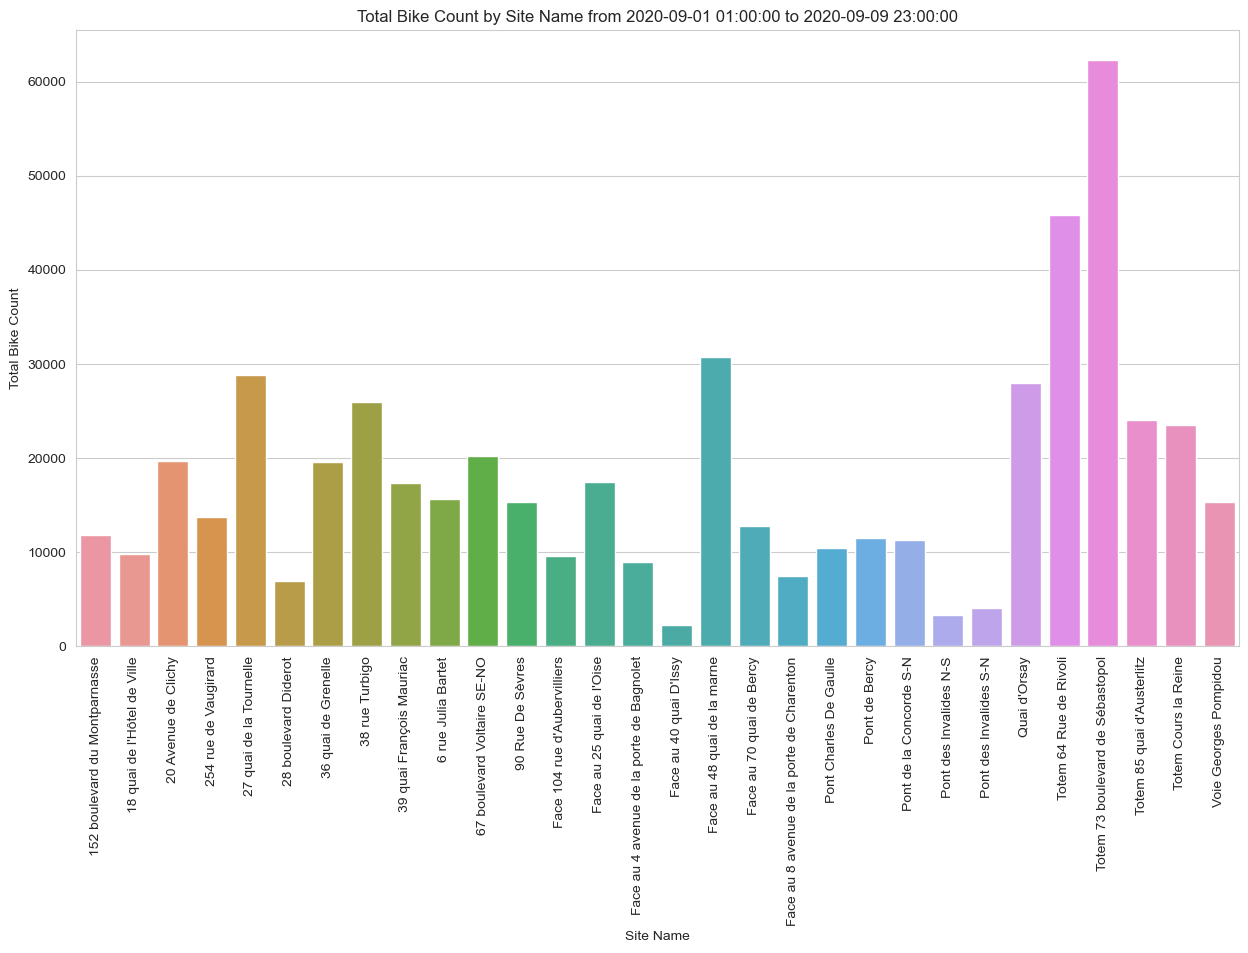

In [29]:
# Group the data by site_name and counter_name and sum the bike_count
grouped_data_train = data_train.groupby(["site_name", "counter_name"])["bike_count"].sum().reset_index()

# Sort the data by bike_count in descending order
grouped_data_sorted = grouped_data_train.sort_values(by="bike_count", ascending=False)

# Create the plot
plt.figure(figsize=(15, 8))  # Adjust the size as needed
sns.barplot(x='site_name', y='bike_count', data=grouped_data_sorted,errorbar=None)

# Improve readability
plt.xticks(rotation=90)  # Rotate site names for better readability
plt.xlabel('Site Name')  # X-axis title
plt.ylabel('Total Bike Count')  # Y-axis title
plt.title('Total Bike Count by Site Name from 2020-09-01 01:00:00 to 2020-09-09 23:00:00')  # Plot title

# Display the plot
plt.show()


We see that "Totem 73 boulevard de Sébastopol" is the most frequented site. Let's see how the distribution of bike_count for this site. Is it linear ? Does it have peaks ? How many counters are there in this site ? 

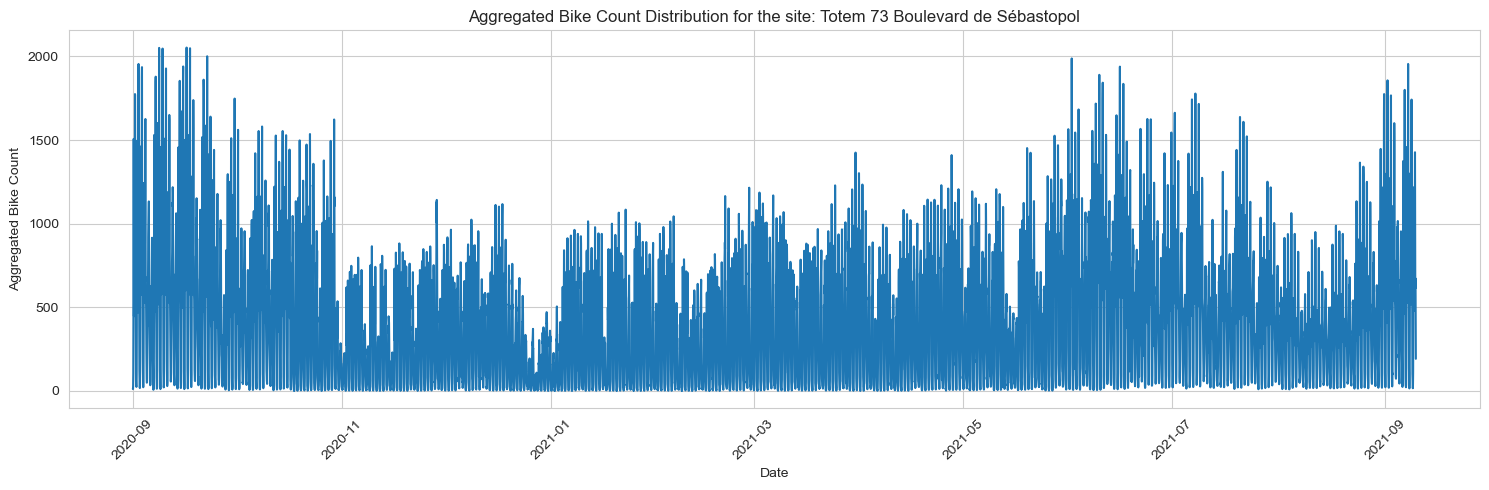

The number of counters at the Totem 73 boulevard de Sébastopol site: 2


In [30]:
# Filtering data for the "Totem 73 boulevard de Sébastopol" site
totem_data = data_train[data_train['site_name'] == "Totem 73 boulevard de Sébastopol"]

# Aggregate bike counts by date
daily_counts = totem_data.groupby('date')['bike_count'].sum().reset_index()

# Plot the aggregated bike_count over time
plt.figure(figsize=(15, 5))
plt.plot(daily_counts['date'], daily_counts['bike_count'], linestyle='-')
plt.title('Aggregated Bike Count Distribution for the site: Totem 73 Boulevard de Sébastopol')
plt.xlabel('Date')
plt.ylabel('Aggregated Bike Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Count the number of unique counters at the "Totem 73 boulevard de Sébastopol" site
print(f"The number of counters at the Totem 73 boulevard de Sébastopol site: {totem_data['counter_name'].nunique()}")


Let's see which of the two counters in this Site are the most popular

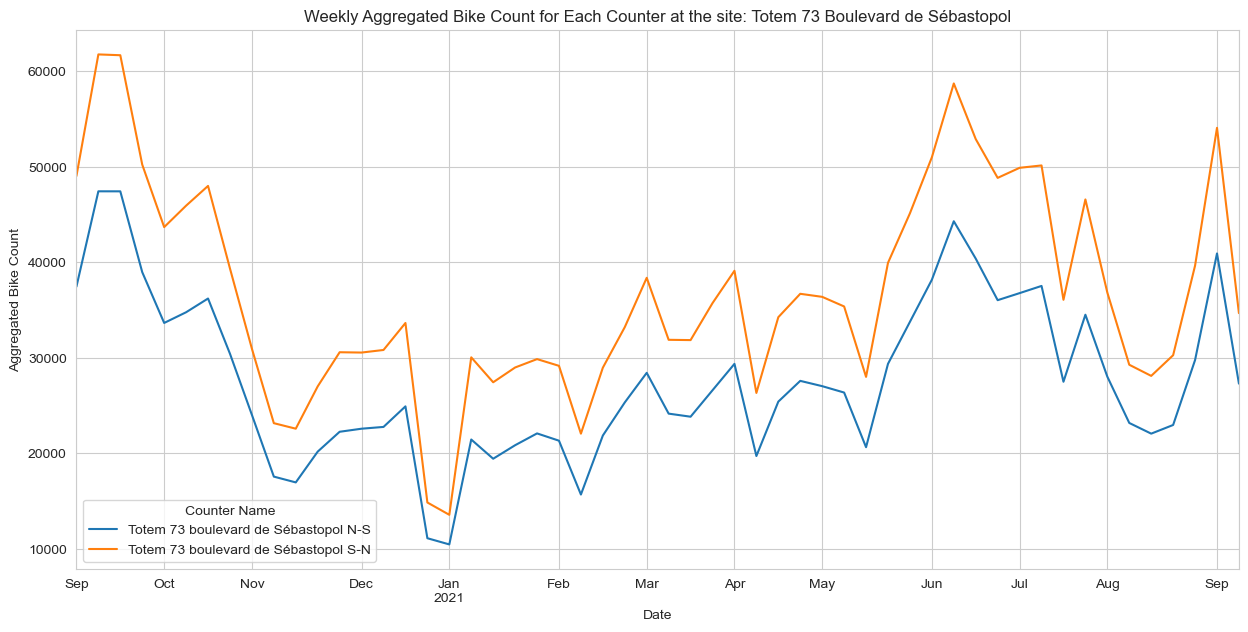

In [31]:
# Create a figure and axis for the plot
plt.figure(figsize=(15, 7))

# Get the list of all unique counters at the "Totem 73 boulevard de Sébastopol" site
unique_counters = totem_data['counter_name'].unique()

# Plot the weekly aggregated bike_count for each counter
for counter in unique_counters:
    # Apply mask for the current counter
    mask = totem_data["counter_name"] == counter
    counter_data = totem_data[mask]

    # Group data by week and sum bike counts
    weekly_counts = counter_data.groupby(pd.Grouper(freq="1w", key="date"))["bike_count"].sum()

    # Plot the data with the counter name as the label
    weekly_counts.plot(label=counter)

# Finalize the plot
plt.title('Weekly Aggregated Bike Count for Each Counter at the site: Totem 73 Boulevard de Sébastopol')
plt.xlabel('Date')
plt.ylabel('Aggregated Bike Count')
plt.legend(title='Counter Name')
plt.show()


Let's now focus on the weekly behaviour of the counters composing 4 Sites we choosed randomly

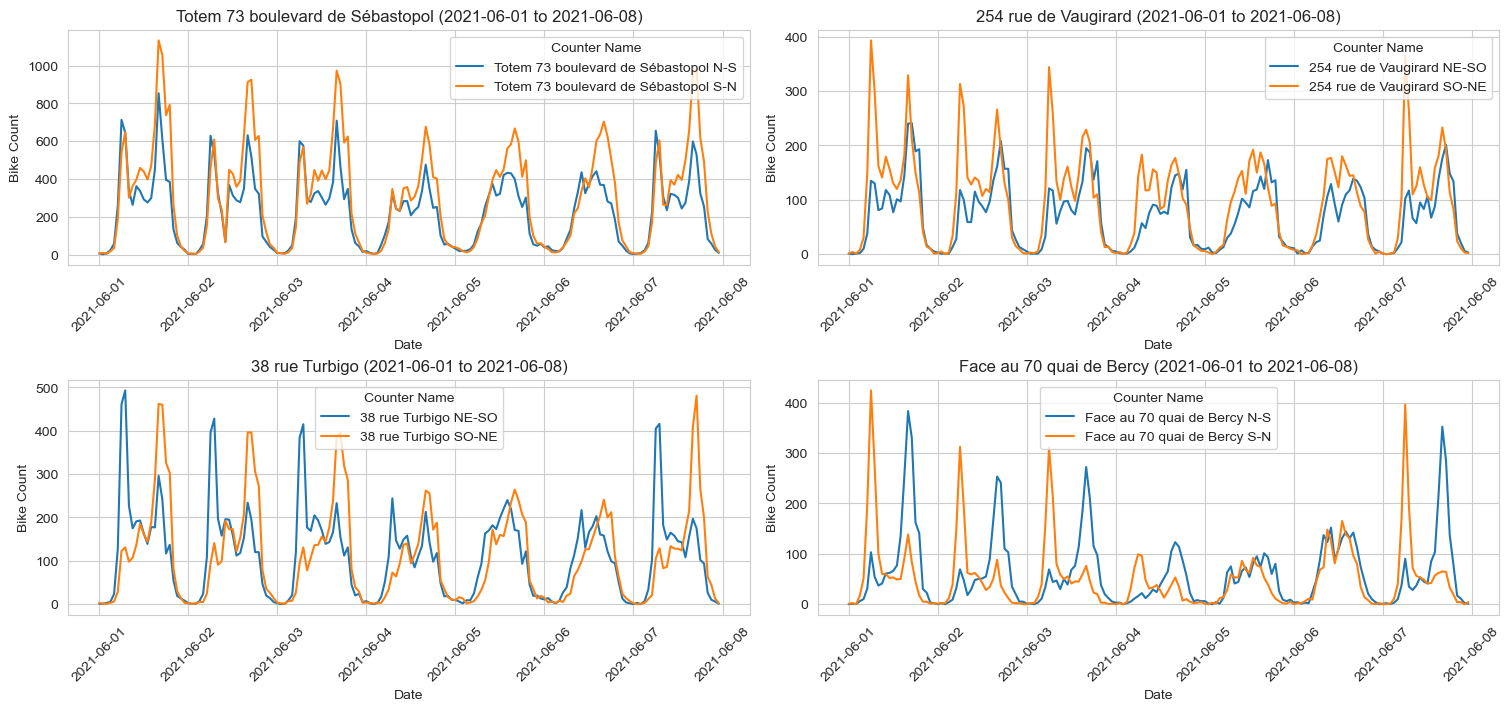

In [32]:
# Define the sites of interest
sites_of_interest = ['Totem 73 boulevard de Sébastopol', '254 rue de Vaugirard', '38 rue Turbigo', 'Face au 70 quai de Bercy']

# Define the time period of interest
start_date = pd.to_datetime("2021-06-01")
end_date = pd.to_datetime("2021-06-08")

# Create a 2x2 subplot structure for the four sites
fig, axs = plt.subplots(2, 2, figsize=(15, 7), constrained_layout=True)

# Flatten the array of axes for easy iteration
axs = axs.flatten()

# Plot the daily bike_count for each counter during the specified week for each site
for idx, site_name in enumerate(sites_of_interest):
    # Filter the data for the given site and week
    site_week_data = data_train[(data_train['site_name'] == site_name) & 
                                (data_train['date'] >= start_date) & 
                                (data_train['date'] < end_date)]

    # Get the list of all unique counters at the current site
    unique_counters = site_week_data['counter_name'].unique()

    # Plot the daily bike_count for each counter
    for counter in unique_counters:
        # Apply mask for the current counter
        mask = site_week_data["counter_name"] == counter
        counter_data = site_week_data[mask]

        # Group data by date and sum bike counts
        daily_counts = counter_data.groupby('date')['bike_count'].sum().reset_index()

        # Plot the data with the counter name as the label on the appropriate subplot
        axs[idx].plot(daily_counts['date'], daily_counts['bike_count'], label=counter)

    # Finalize each subplot
    axs[idx].set_title(f'{site_name} (2021-06-01 to 2021-06-08)')
    axs[idx].set_xlabel('Date')
    axs[idx].set_ylabel('Bike Count')
    axs[idx].legend(title='Counter Name')
    axs[idx].tick_params(axis='x', rotation=45)

# Adjust the layout so that all subplots fit into the figure neatly
plt.show()

Why should we use the target variable as log(count_bike) instead of count_bike ?

Because we see that the hourly pattern has a clear variation between work days and weekends. If we look at the distribution of the target variable it skewed and non normal.

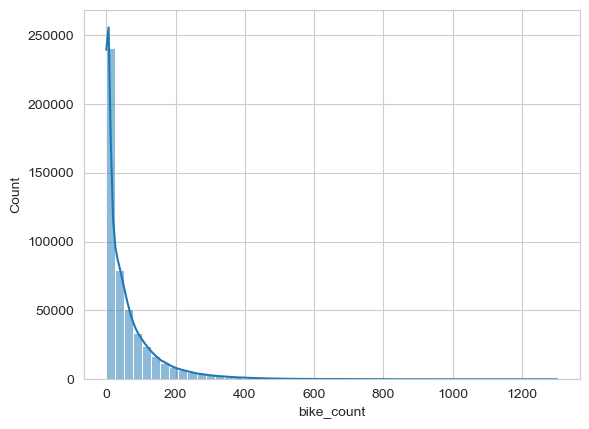

In [33]:
ax = sns.histplot(data_train, x="bike_count", kde=True, bins=50)

The histogram indicates that the bike_count data is highly skewed to the right, with a large number of counts close to zero and few counts reaching higher values. The KDE line, which is the smooth curve on the histogram, confirms this skewness by showing the peak near the lower end of the bike_count range and a long tail stretching towards the higher counts.

We deduce that: Least square loss would not be appropriate to model it since it is designed for normal error distributions. One way to precede would be to transform the variable with a logarithmic transformation,
```py
data['log_bike_count'] = np.log(1 + data['bike_count'])
```

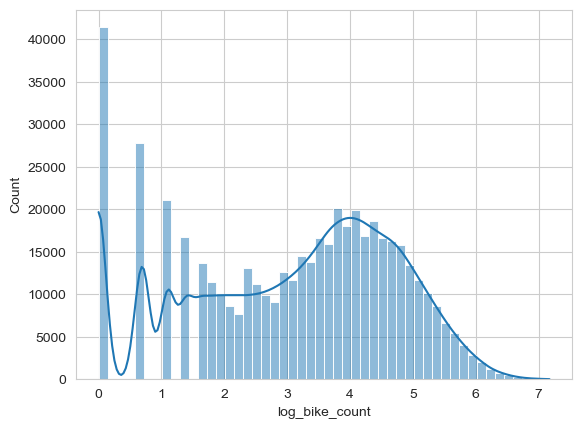

In [34]:
ax = sns.histplot(data_train, x="log_bike_count", kde=True, bins=50)

Conclusion: it has a more pronounced central mode, but is still non symmetric. In the following, **we use `log_bike_count` as the target variable** as otherwise `bike_count` ranges over 3 orders of magnitude and least square loss would be dominated by the few large values. 

-----------------------------------------------------------------------------------------------
#### 3) How to handle missing values ? (Replace them, Predict them)

Let's not be tricked in our dataset: there are no missing values but a lot (~8%) of values for bike_count that are null for certain counters which is certainly a bug of the counter (and not related to covid when we see the dates)

Let's visualize the null values by taking the example of two sites: "152 Boulevard du Montparnasse" and "20 Avenue de Clichy"

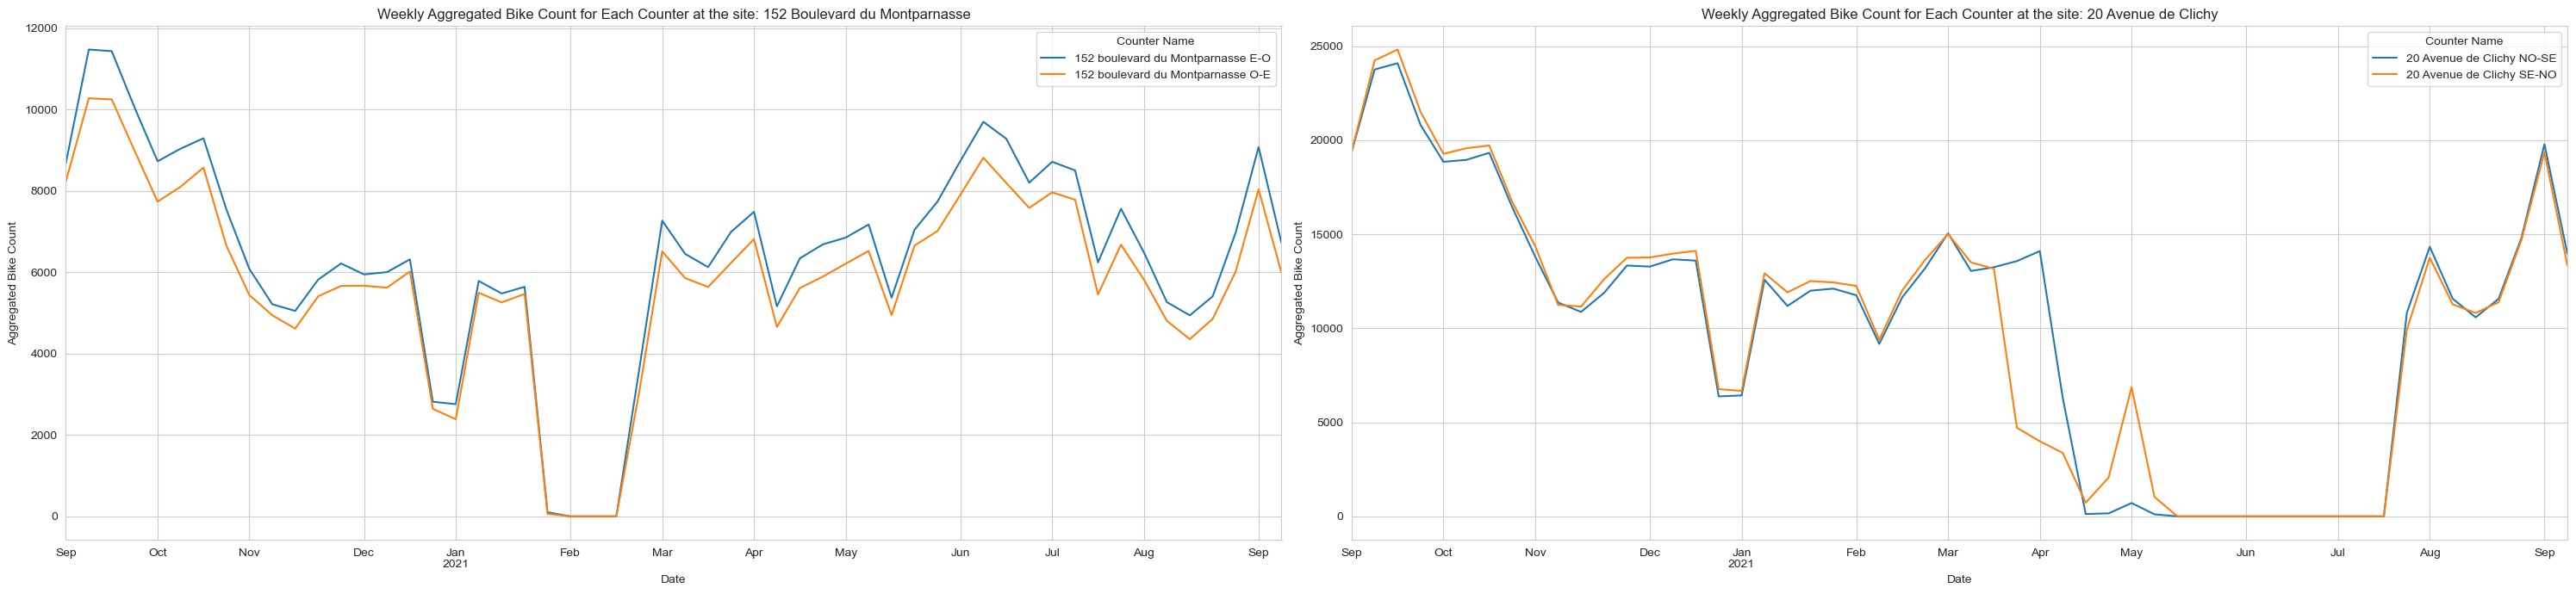

In [43]:
# Create a figure for the subplots
plt.figure(figsize=(30, 7))  # La largeur est doublée pour accueillir deux graphes côte à côte.

# Subplot for "152 boulevard du Montparnasse"
plt.subplot(1, 2, 1)  # 1 ligne, 2 colonnes, position 1

# Filtering and plotting for "152 boulevard du Montparnasse"
montparnasse_data = data_train[data_train['site_name'] == "152 boulevard du Montparnasse"]
unique_counters_montparnasse = montparnasse_data['counter_name'].unique()
for counter in unique_counters_montparnasse:
    counter_data = montparnasse_data[montparnasse_data["counter_name"] == counter]
    weekly_counts = counter_data.groupby(pd.Grouper(freq="1w", key="date"))["bike_count"].sum()
    weekly_counts.plot(label=counter)

# Finalize the subplot
plt.title('Weekly Aggregated Bike Count for Each Counter at the site: 152 Boulevard du Montparnasse')
plt.xlabel('Date')
plt.ylabel('Aggregated Bike Count')
plt.legend(title='Counter Name')

# Subplot for "20 Avenue de Clichy"
plt.subplot(1, 2, 2)  # 1 ligne, 2 colonnes, position 2

# Filtering and plotting for "20 Avenue de Clichy"
clichy_data = data_train[data_train['site_name'] == "20 Avenue de Clichy"]
unique_counters_clichy = clichy_data['counter_name'].unique()
for counter in unique_counters_clichy:
    counter_data = clichy_data[clichy_data["counter_name"] == counter]
    weekly_counts = counter_data.groupby(pd.Grouper(freq="1w", key="date"))["bike_count"].sum()
    weekly_counts.plot(label=counter)

# Finalize the subplot
plt.title('Weekly Aggregated Bike Count for Each Counter at the site: 20 Avenue de Clichy')
plt.xlabel('Date')
plt.ylabel('Aggregated Bike Count')
plt.legend(title='Counter Name')

# Show the figure with subplots
plt.tight_layout()  
plt.show()


We see null values for 20 days for Montparnasse site and and 3 months for Avenue Clichy which is not normal, we can suppose that the counters there were either bugged or they were under construction. What should we do with theses null values ?
- We will apply different methods to handle this problem:
1) Replace them 
2) Predict them


-----------------------------------------------------------------------------------------------
#### 4) Deal with highly correlated variables (correlation matrix, PCA)

First, let's calculate the correlation matrix (only for float or int variables)

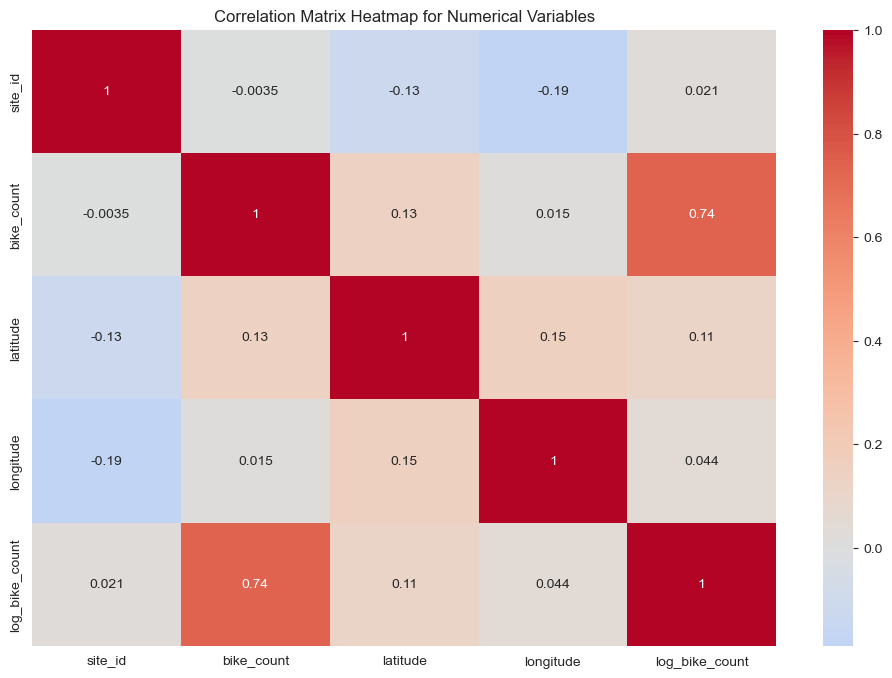

In [47]:
# Filter the DataFrame to include only float or int types
numerical_data_train = data_train.select_dtypes(include=[np.float64, np.int64])

# Calculate the correlation matrix for numerical variables only
correlation_matrix_numerical = numerical_data_train.corr()

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_numerical, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix Heatmap for Numerical Variables')
plt.show()


The heatmap of the correlation matrix for numerical variables indicates that there are no particularly strong correlations between the different variables, except for the `bike_count` and its logarithmic transformation `log_bike_count`, which is normal. This strong correlation is expected since `log_bike_count` is directly derived from `bike_count`. The lack of strong correlations among the remaining variables suggests that multicollinearity is not a concern for this train dataset, and thus there is no immediate need to remove any explanatory variables based on the correlation analysis alone. This is beneficial because it allows us to retain all the numerical variables for further analysis without worrying about the adverse effects that highly correlated predictors can have on some models.

Now, let's perform PCA to understand the contribution of each variable

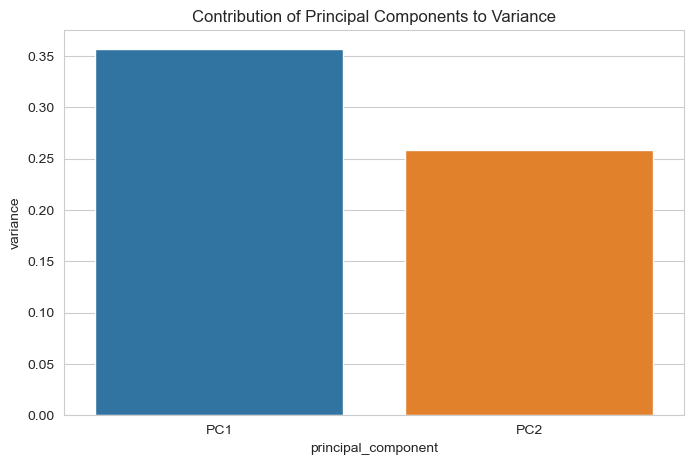

Principal components:
[[-0.05144927  0.68132122  0.24253011  0.11094124  0.67972462]
 [ 0.60865684  0.1521784  -0.46157881 -0.60710376  0.15731692]]


In [46]:
# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_train.select_dtypes(include=np.number))  # Only select numerical columns

# Apply PCA
pca = PCA(n_components=2)  # Adjust the number of components as required
pca.fit(data_scaled)

# Get the PCA results
pca_results = pd.DataFrame({'variance': pca.explained_variance_ratio_,
                            'principal_component': ['PC1', 'PC2']})

# Visualize the contributions of each principal component to the total variance
plt.figure(figsize=(8, 5))
sns.barplot(x='principal_component', y='variance', data=pca_results)
plt.title('Contribution of Principal Components to Variance')
plt.show()

# Display the components
print('Principal components:')
print(pca.components_)

# With the PCA components, you can observe the contributions of each feature.
# The larger the absolute value of the coefficient, the more important the corresponding feature is in calculating the component.

The first principal component (PC1) accounts for a larger proportion of the variance compared to the second principal component (PC2). This is indicative of the fact that PC1 captures more information about the dataset than PC2.

It is important to note that PCA is a dimensionality reduction technique that combines your original variables in a way that the new axes (principal components) are orthogonal to each other, thereby removing any correlation between them. The PCA loadings (the principal components matrix) tell you how each original variable contributes to each principal component.

The decision to remove explanatory variables based on PCA is not straightforward. PCA can inform you about the underlying structure of your data and can suggest which variables might be redundant, but whether to remove variables should be based on a combination of PCA results and domain knowledge.

Given the lack of strong correlations (except between `bike_count` and `log_bike_count`) and the fact that PCA is not explicitly suggesting the removal of variables, we may not need to eliminate any explanatory variables at this point. It is generally best to consider both statistical evidence and domain knowledge when deciding to remove features from your model.